

##Testing IFD
###Dataset : Electrical-fault-detection-and-classification
####Data_set_link : "https://github.com/KingArthur000/Electrical-Fault-detection-and-classification "
####My GitHUb_link = "https://github.com/Tusharkn12/Intelligent-Fault-Detection-IFD "


In [ ]:
from ifd import IFD
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import sklearn as sk
from ifd import DataGenerator
from xgboost import XGBClassifier as XGB
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, BatchNormalization, Dropout, MaxPooling2D, Multiply, Input, LSTM, GRU, ZeroPadding2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow.keras.utils import plot_model

In [ ]:
def extended_tanh(x):
  "Extending tanh to give output between [-3, 3]"
  simple_tanh = (tf.exp(x) - tf.exp(-x))/(tf.exp(x) + tf.exp(-x))
  return 3*simple_tanh

In [ ]:
data_set = pd.read_csv("/content/60.416.csv")

In [ ]:
data_set.head()

,cl1,cl2,cl3,cl4,cl5,cl6,cl7,cl8
0,-0.72819,1.11200,0.109290,0.379410,0.040286,0.015388,0.52117,-0.150310
1,-0.71638,1.06700,-0.085559,0.316530,0.040382,0.019720,0.43941,0.033369
2,-0.71757,1.32750,-0.064726,0.340750,0.041731,0.016973,0.39931,-0.074302
3,-0.72706,0.95937,-0.060435,0.155150,0.046381,0.021985,0.39251,-0.057436
4,-0.71088,0.75190,-0.675710,-0.017809,0.045642,0.018873,0.29961,0.021419


In [ ]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cl1     250000 non-null  float64
 1   cl2     250000 non-null  float64
 2   cl3     250000 non-null  float64
 3   cl4     250000 non-null  float64
 4   cl5     250000 non-null  float64
 5   cl6     250000 non-null  float64
 6   cl7     250000 non-null  float64
 7   cl8     250000 non-null  float64
dtypes: float64(8)
memory usage: 15.3 MB


In [ ]:
data_set.describe()

,cl1,cl2,cl3,cl4,cl5,cl6,cl7,cl8
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,-0.001323,0.002044,-0.000246,0.000569,0.002452,0.002041,0.001453,0.010941
std,1.781814,0.594890,0.498967,0.282529,0.225419,0.044311,0.823892,0.214199
min,-1.453300,-3.040300,-2.458100,-1.396800,-0.931720,-0.170640,-2.865800,-0.468260
25%,-0.747950,-0.391120,-0.345143,-0.187480,-0.131150,-0.027160,-0.606295,-0.170070
50%,-0.722550,0.019726,0.000520,-0.000149,0.029387,0.004697,0.116385,-0.008590
75%,-0.616177,0.414153,0.338383,0.186920,0.161422,0.033646,0.619805,0.170440
max,4.906700,2.280100,2.451700,1.460000,0.531490,0.137420,2.517500,0.847180


In [ ]:
scaler = StandardScaler()
data_transformed = scaler.fit_transform(data_set)
X_train, X_test = train_test_split(data_transformed, test_size = 0.2, random_state = 42, shuffle= False)

<Axes: >

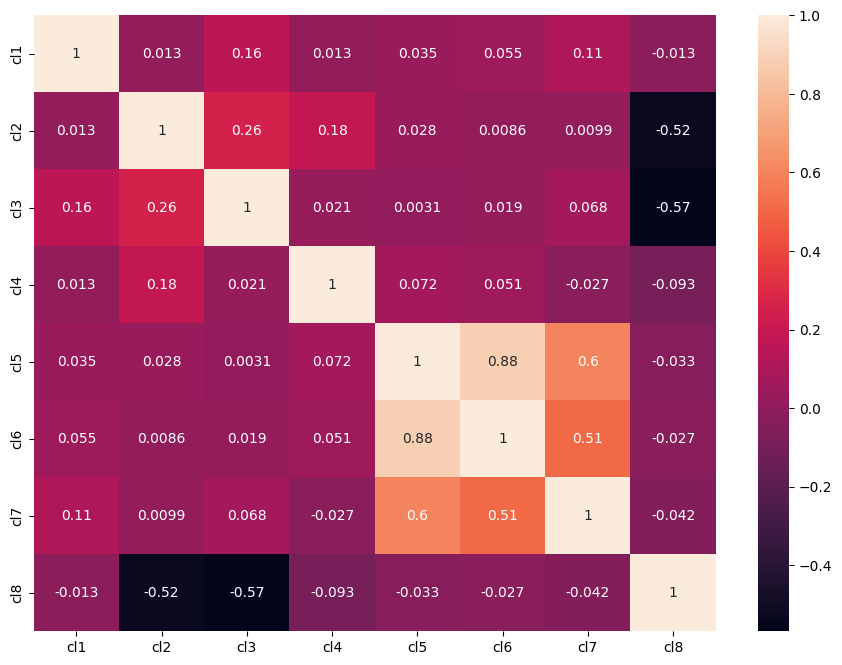

In [ ]:
plt.figure(figsize = (11, 8))
sns.heatmap(data_set.corr(), annot = True)

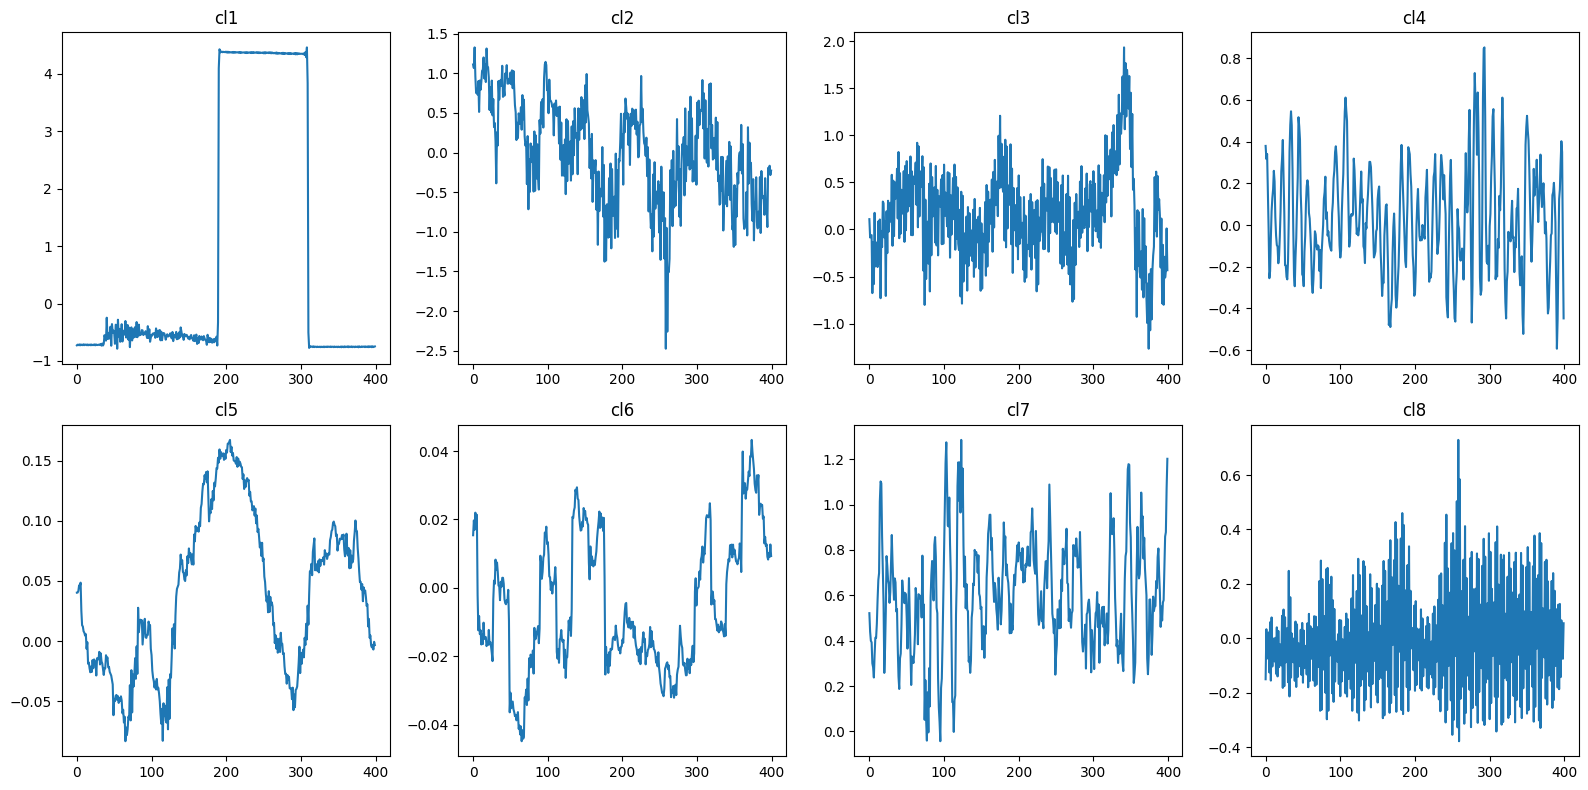

In [ ]:
ig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))  # Adjust figsize as needed

# Flatten the axes array for easier iteration
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.plot(data_set.iloc[:400, i])  # Plot data on the current subplot
    ax.set_title(data_set.columns[i])  # Set title for the subplot

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [ ]:
##Making dataset ready for ifd
X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)
X_train = tf.random.shuffle(tf.reshape(tf.split(X_train, num_or_size_splits = 400, axis = 0),shape = (-1, 400, 8)))#Total 500
X_test = tf.random.shuffle(tf.reshape(tf.split(X_test, num_or_size_splits = 400, axis = 0), shape = (-1, 400, 8)))#Total 125

In [ ]:
X_val=  X_test[:int(0.5*len(X_test)), :, :]
X_test = X_test[int(0.5*len(X_test)):, :, :]

In [ ]:
ifd = IFD(transformed_img_shape = (20, 20), n_f = 8, T_x = 400, num_pred = 0, batch_size = 32, replace_part = True)

In [ ]:
#############################################################################
################   AutoEncoder Architecture   ##############################
############################################################################

inp = Input(shape = (20, 20, 24), name = "input") #(20, 20)
conv1 = Conv2D(60, (3,3), kernel_initializer = "he_normal", padding = "same")(inp)#(20, 20)
conv1_norm = BatchNormalization()(conv1)
conv1_act = relu(conv1_norm)
conv1_act = Dropout(0.3)(conv1_act)

conv2 = Conv2D(40, (3,3), kernel_initializer = "he_normal")(conv1_act)#(18,18)
conv2_norm = BatchNormalization()(conv2)
conv2_act = relu(conv2_norm)
conv2_act = Dropout(0.3)(conv2_act)

conv3 = Conv2D(20, (3,3), kernel_initializer = "he_normal")(conv2_act)#(16, 16)
conv3_norm = BatchNormalization()(conv3)
conv3_act = relu(conv3_norm)

conv4 = Conv2D(15, (3,3), kernel_initializer = "he_normal")(conv3_act)#(14, 14)
conv4_norm = BatchNormalization()(conv4)
conv4_act = relu(conv4_norm)

conv3_act = MaxPooling2D((2, 2), strides = 2, name = "Middle")(conv4_act) #(7, 7)

# Decoder Model (Mirror of Encoder)
deconv1 = Conv2DTranspose(15, (2, 2), strides =2, kernel_initializer="he_normal")(conv3_act)  #(14, 14)
deconv1_norm = BatchNormalization()(deconv1)
deconv1_act = relu(deconv1_norm)

deconv2 = Conv2DTranspose(20, (3, 3), kernel_initializer="he_normal")(deconv1_act)  #(16, 16)
deconv2_norm = BatchNormalization()(deconv2)
deconv2_act = relu(deconv2_norm)
deconv2_act = Dropout(0.3)(deconv2_act)

deconv3 = Conv2DTranspose(40, (3, 3), kernel_initializer="he_normal")(deconv2_act) #(18, 18)
deconv3_norm = BatchNormalization()(deconv3)
deconv3_act = relu(deconv3_norm)
deconv3_act = Dropout(0.3)(deconv3_act)

deconv4 = Conv2DTranspose(60, (3, 3), kernel_initializer="he_normal")(deconv3_act) #(20, 20)
deconv4_norm = BatchNormalization()(deconv4)
deconv4_act = relu(deconv4_norm)
deconv4_act = Dropout(0.3)(deconv4_act)

# Final Output Layer
output = Conv2DTranspose(24, (3, 3), activation= extended_tanh, name="output", padding = "same")(deconv4_act)  # (20, 20, 24)

auto_encoder = Model(inputs = [inp], outputs = [output])


In [ ]:
ifd.set_conv_layer(conv_model = auto_encoder, auto_encoder = True)
ifd.set_Data_generator()

conv_layer is created
DataGenerator is created


In [ ]:
ifd.conv_layer.conv_model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 20, 20, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 20, 20, 60)          │          13,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_48               │ (None, 20, 20, 60)          │             240 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_48 (ReLU)                      │ (None, 20, 20, 60)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 20, 20, 60)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 18, 18, 40)          │          21,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_49               │ (None, 18, 18, 40)          │             160 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_49 (ReLU)                      │ (None, 18, 18, 40)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 18, 18, 40)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 16, 16, 20)          │           7,220 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_50               │ (None, 16, 16, 20)          │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_50 (ReLU)                      │ (None, 16, 16, 20)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 14, 14, 15)          │           2,715 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_51               │ (None, 14, 14, 15)          │              60 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_51 (ReLU)                      │ (None, 14, 14, 15)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Middle (MaxPooling2D)                │ (None, 7, 7, 15)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_24                  │ (None, 14, 14, 15)          │             915 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_52               │ (None, 14, 14, 15)          │              60 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 91,194 (356.23 KB)

 Trainable params: 90,654 (354.12 KB)

 Non-trainable params: 540 (2.11 KB)

In [ ]:
model = ifd.create_model()

DataGenerator and Conv_layer is merged


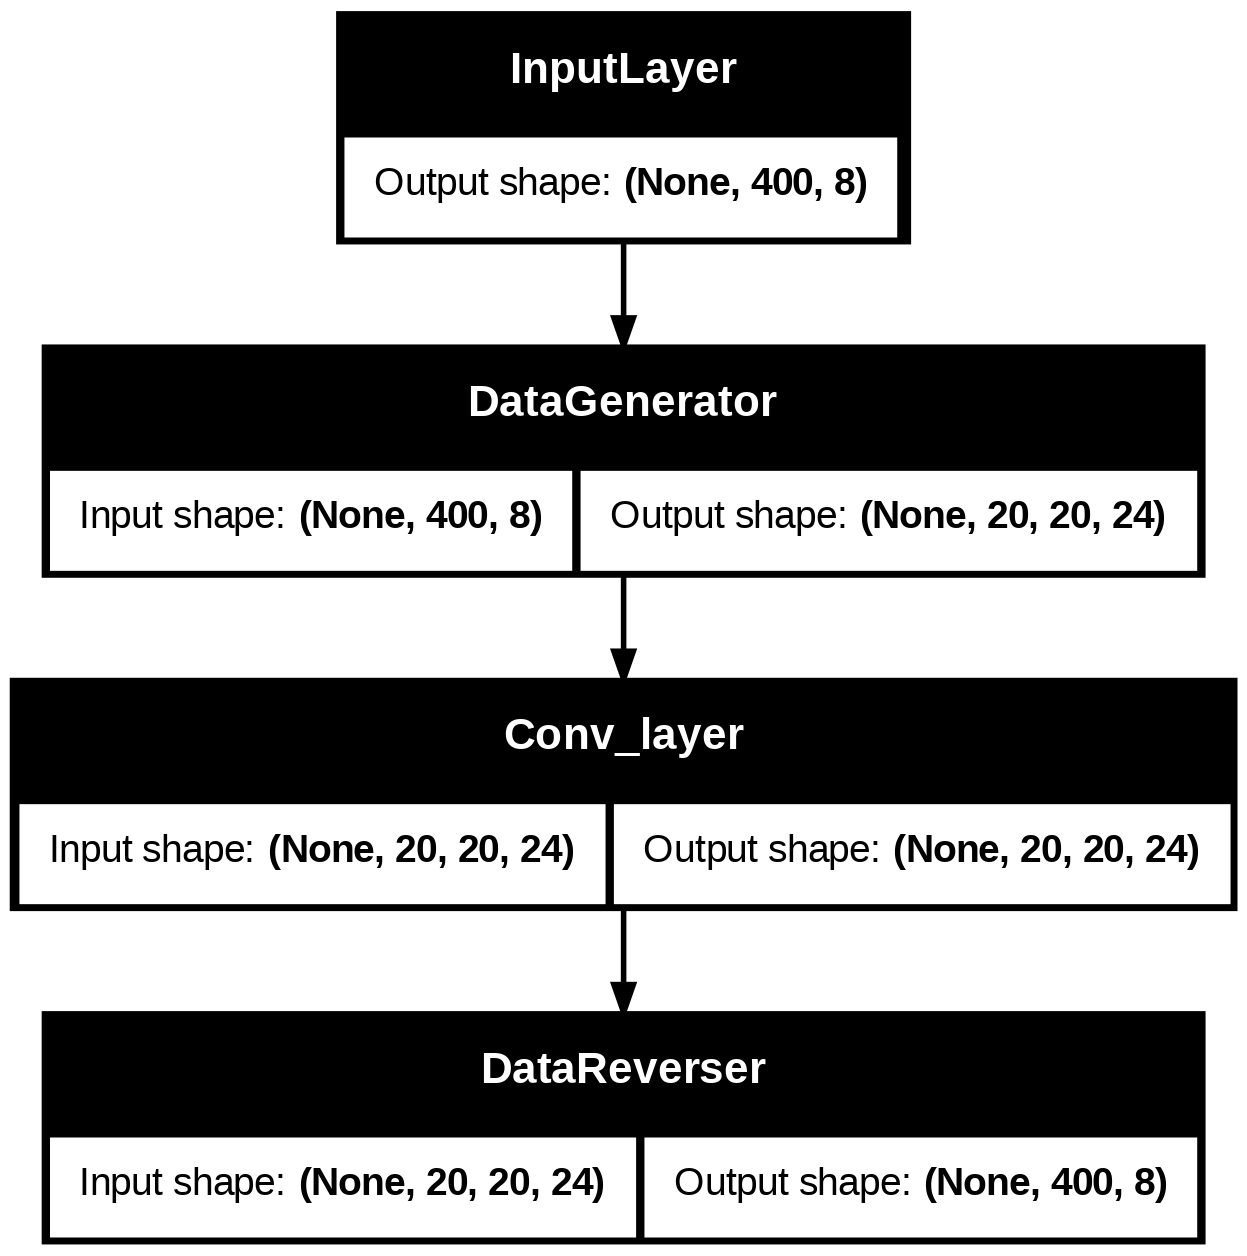

In [ ]:
plot_model(model, show_shapes = True)

In [ ]:
model.compile(optimizer = "adam", loss = "mse")

In [ ]:
his = model.fit(X_train, tf.identity(X_train), epochs = 100, batch_size = 32, validation_data = (X_val, tf.identity(X_val)))

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 357ms/step - loss: 2.6013 - val_loss: 1.3816
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 262ms/step - loss: 1.3787 - val_loss: 1.2625
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 284ms/step - loss: 1.2765 - val_loss: 1.2055
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 440ms/step - loss: 1.2427 - val_loss: 1.1354
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 236ms/step - loss: 1.1674 - val_loss: 1.0888
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 271ms/step - loss: 1.0858 - val_loss: 1.0199
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - loss: 1.0556 - val_loss: 0.9741
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - loss: 0.9805 - val_loss: 0.9452
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 264ms/step - loss: 0.9732 - val_loss: 0.8967
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 269ms/step - loss: 0.9328 - val_loss: 0.9098
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - loss: 0.9048 - val_loss: 0.8756
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
#Taking abnormal events in dataset too
data_set_abnorm = pd.read_csv("/content/60.416 (2).csv")
X_test_abnorm = scaler.fit_transform(data_set_abnorm)
X_test_abnorm = tf.convert_to_tensor(X_test_abnorm)

X_test_abnorm = tf.concat([X_test_abnorm, tf.expand_dims(X_test_abnorm[1, :], axis = 0)], axis = 0)
X_test_abnorm = tf.split(X_test_abnorm, num_or_size_splits = 400, axis = 0)
X_test_abnorm = tf.random.shuffle(tf.reshape(X_test_abnorm, shape = (-1, 400, 8)))
tf.shape(X_test_abnorm)


<tf.Tensor: shape=(3,), dtype=int32, numpy=array([625, 400,   8], dtype=int32)>

In [ ]:
model.evaluate(X_test_abnorm, tf.identity(X_test_abnorm))

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.6896


0.6880791783332825

In [ ]:
model.evaluate(X_test, tf.identity(X_test))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.5428


0.5491299033164978

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 397ms/step


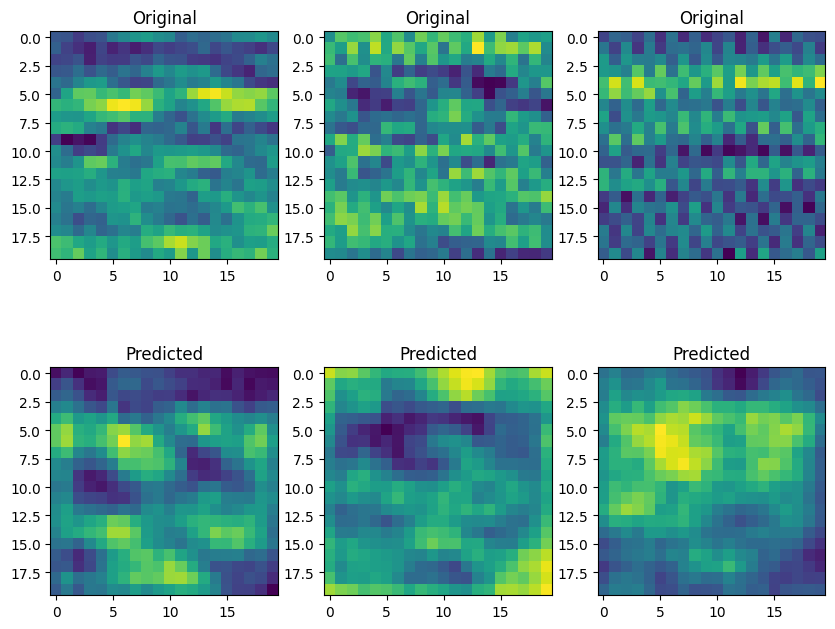

In [ ]:
X_test_auto_pred = model.predict(X_test)
generator = DataGenerator(img_shape = (20, 20), n_f = 8)

img_generator_output_pred = generator(X_test_auto_pred)
img_generator_output = generator(X_test)

plt.figure(figsize = (10, 8))
for i in range(0, 3):
  plt.subplot(2, 3, i + 1)
  plt.imshow(img_generator_output[5, :, :, i])
  plt.title("Original")
  plt.subplot(2, 3, i + 4)
  plt.imshow(img_generator_output_pred[5, :, :, i ])
  plt.title("Predicted")

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step


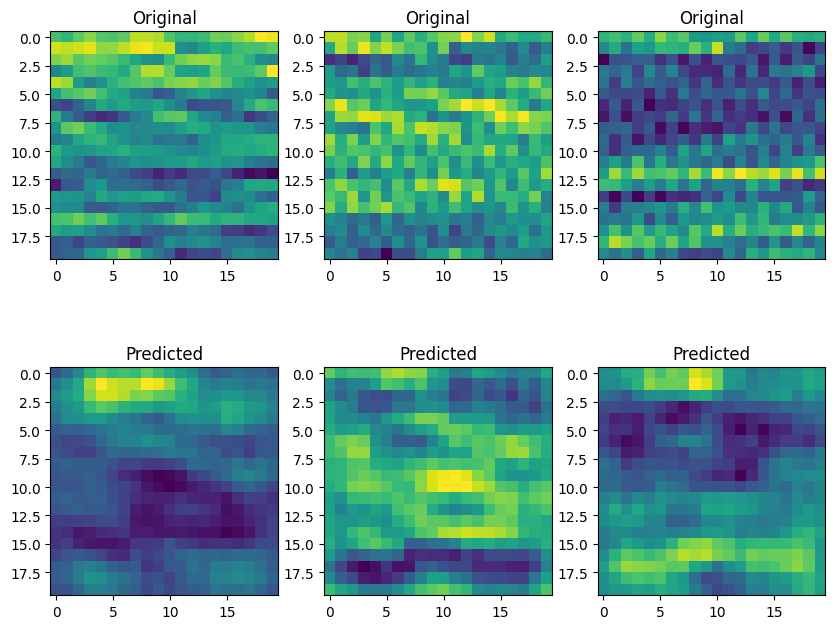

In [ ]:
X_test_auto_pred = model.predict(X_test_abnorm)
generator = DataGenerator(img_shape = (20,20), n_f = 8)

img_generator_output_pred = generator(X_test_auto_pred)
img_generator_output = generator(X_test_abnorm)

plt.figure(figsize = (10, 8))
for i in range(0, 3):
  plt.subplot(2, 3, i + 1)
  plt.imshow(img_generator_output[5, :, :, i])
  plt.title("Original")
  plt.subplot(2, 3, i + 4)
  plt.imshow(img_generator_output_pred[5, :, :, i ])
  plt.title("Predicted")


In [ ]:
X_test_comb = tf.concat([X_train, X_test_abnorm], axis = 0)
y_train = tf.concat([tf.zeros(len(X_train)), tf.ones(len(X_test_abnorm))], axis = 0)

In [ ]:
threshold_list = np.arange(0.6, 1.0, 0.02)
f1_score_list = []
y_pred = tf.reduce_sum(tf.square(tf.subtract(X_test_comb, model.predict(X_test_comb))), axis = [1, 2])/3200
for threshold in threshold_list:
  y_pred = np.where(y_pred >= threshold , 1, 0)
  f1_score_list.append(f1_score(y_train, y_pred))

36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 183ms/step


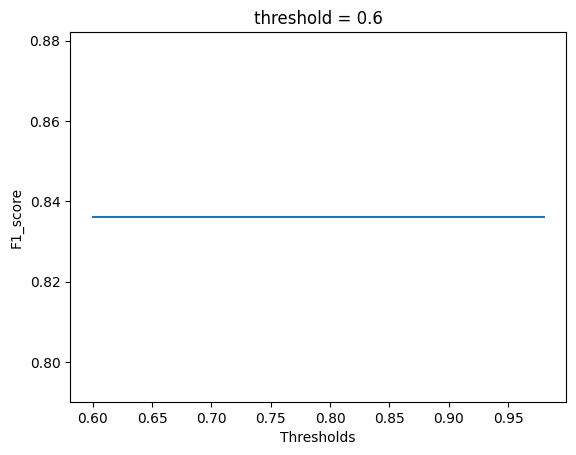

In [ ]:
plt.plot(threshold_list, f1_score_list)
plt.ylabel("F1_score")
plt.xlabel("Thresholds")
plt.title("Thresold vs F1_score")
plt.title(f"threshold = {threshold_list[np.argmax(f1_score_list)]}")
plt.show()

In [ ]:
threshold_auto = threshold_list[np.argmax(f1_score_list)]
y_pred = tf.reduce_sum(tf.square(tf.subtract(X_test_comb, model.predict(X_test_comb))), axis = [1, 2])/3200
y_pred = np.where(y_pred >= threshold_auto , 1, 0)
print(f1_score(y_train, y_pred))
cm = confusion_matrix(y_train, y_pred)

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step
0.8342585249801745


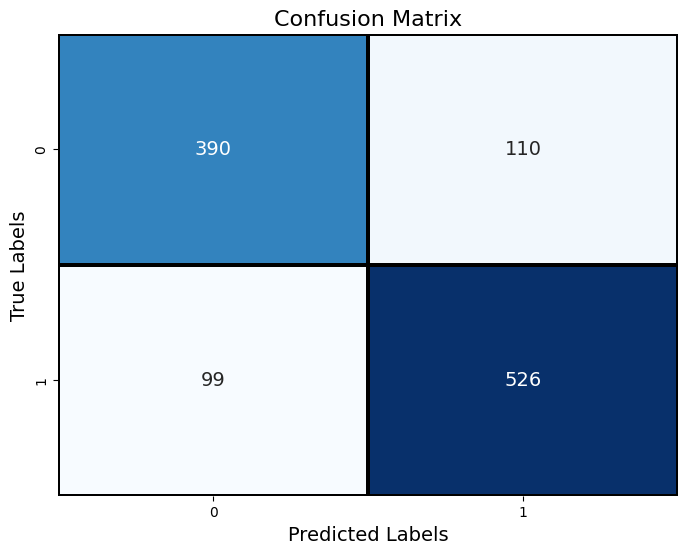

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", cbar = False,
            annot_kws = {"size":14}, linewidths = 1.5, linecolor = "black")
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

In [ ]:
#making convxgb
xgb = XGB(n_estimators = 300, min_depth = 5, verbosity = 3, booster = "gbtree", early_stopping_round = 20, eval_metrics = ["f1_score"], shuffle = True)
ConvXGb = ifd.create_and_train_ConvXGB(model, xgb, X_test_comb, y_train)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Inputs (InputLayer)                  │ (None, 400, 8)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_generator_13 (DataGenerator)    │ (None, 20, 20, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_11 (Functional)           │ (None, 7, 7, 15)            │          45,135 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 735)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,135 (176.31 KB)

 Trainable params: 44,865 (175.25 KB)

 Non-trainable params: 270 (1.05 KB)

[18:13:14] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[18:13:14] DEBUG: /workspace/src/data/simple_dmatrix.cc:179: Generating new Gradient Index.
[18:13:15] ======== Monitor (0): HostSketchContainer ========
[18:13:15] AllReduce: 0.059743s, 1 calls @ 59743us

[18:13:15] MakeCuts: 0.073879s, 1 calls @ 73879us

[18:13:15] PushRowPage: 0.05912s, 1 calls @ 59120us



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:13:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "early_stopping_round", "eval_metrics", "min_depth", "shuffle" } are not used.

  warnings.warn(smsg, UserWarning)


[18:13:32] ======== Monitor (0): Learner ========
[18:13:32] Configure: 0.013577s, 1 calls @ 13577us

[18:13:32] EvalOneIter: 0.003917s, 300 calls @ 3917us

[18:13:32] GetGradient: 0.100832s, 300 calls @ 100832us

[18:13:32] PredictRaw: 0.001268s, 300 calls @ 1268us

[18:13:32] UpdateOneIter: 17.6209s, 300 calls @ 17620850us

[18:13:32] ======== Monitor (0): GBTree ========
[18:13:32] BoostNewTrees: 17.4974s, 300 calls @ 17497402us

[18:13:32] CommitModel: 0.000539s, 300 calls @ 539us

[18:13:32] ======== Monitor (0): HistUpdater ========
[18:13:32] BuildHistogram: 5.01055s, 1053 calls @ 5010546us

[18:13:32] EvaluateSplits: 8.7694s, 1353 calls @ 8769398us

[18:13:32] InitData: 0.456801s, 300 calls @ 456801us

[18:13:32] InitRoot: 3.62441s, 300 calls @ 3624409us

[18:13:32] LeafPartition: 0.000136s, 300 calls @ 136us

[18:13:32] UpdatePosition: 1.18894s, 1126 calls @ 1188944us

[18:13:32] UpdatePredictionCache: 0.0909s, 300 calls @ 90900us

[18:13:32] UpdateTree: 17.3917s, 300 calls @ 

In [ ]:
pre_convxgb_auto_pred = ConvXGb.pre_xgb_model.predict(X_test_comb)
convxgb_auto_pred = ConvXGb.XGB_model.predict(pre_convxgb_auto_pred)

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step


In [ ]:
print(f1_score(y_train, convxgb_auto_pred))
cm = confusion_matrix(y_train, convxgb_auto_pred)

1.0


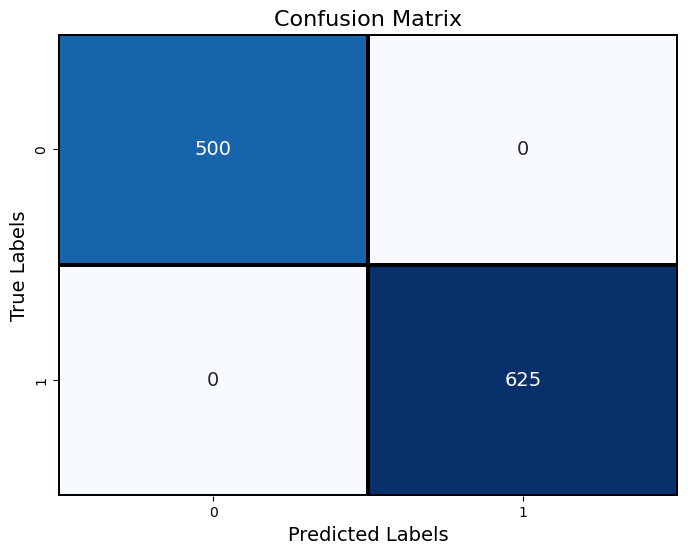

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", cbar = False,
            annot_kws = {"size":14}, linewidths = 1.5, linecolor = "black")
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()